# Modelling

2 classification algorithms are trained, validated and tested in this notebook.
- multinominal logistic regression
- feed-forward neural network

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Prepare data

In [2]:
# feature NOT to use: 
#   - birthday before 1920:                 unrealistic age of people because stored were opened during "the last couple of years" (2024 rows were dropped)
#   - total_traveltime:                     not needed because sum of flight time and layover time (besides for 4123 rows, there are deviations in the sum but less than 1min)
#   - flight numbers:                       too individual
#   - departure and destination airports:   these information alone does not help to predict revenue.
#   - shopped_at:                           EU airports differs from non-EU airports

In [3]:
### load data

passengersEU = pd.read_csv('../data/processed/passengersEU.csv', index_col=0)
passengersWW = pd.read_csv('../data/processed/passengersWW.csv', index_col=0)
airports = pd.read_csv('../data/processed/airports.csv', index_col=0)
airports_terms_of_lease = pd.read_csv('../data/processed/airports_terms_of_lease.csv', index_col=0)
passenger_traffic_2019 = pd.read_csv('../data/processed/passenger_traffic_2019.csv', index_col=0)

C:\Users\marc-\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# check if EU airports are really located in EU and some for WW
print(pd.merge(passengersEU, airports, left_on=['shopped_at'], right_on=['iata_code'])['continent'].value_counts())
print(pd.merge(passengersWW, airports, left_on=['shopped_at'], right_on=['iata_code'])['continent'].value_counts())
# -> all fine

EU    116066
Name: continent, dtype: int64
AS    39593
NH    17820
SA     5582
OC     4771
Name: continent, dtype: int64


In [5]:
### normalize and one-hot encoding data

# define dataset
features_num = ['business_trip','traveled_with_family','total_flighttime','layover_time','luggage_size','age']
features_cat =['sex','luggage_type','shopped_at_stage'] #,'airline_1','airline_2']

X_num = passengersEU[features_num]
X_cat = passengersEU[features_cat]

WW_num = passengersWW[features_num]
WW_cat = passengersWW[features_cat]

# normalize (min-max scalling) numeric features
scaler = MinMaxScaler()
scaler.fit(X_num)
X_num_scaled = scaler.transform(X_num)

WW_num_scaled = scaler.transform(WW_num)

# X_num_std = (X_num - X_num.min(axis=0)) / (X_num.max(axis=0) - X_num.min(axis=0))
# X_num_scaled = X_num_std * (1 - 0) + 0

# WW_num_std = (WW_num - WW_num.min(axis=0)) / (WW_num.max(axis=0) - WW_num.min(axis=0))
# WW_num_scaled = WW_num_std * (1 - 0) + 0

# one hot encoding for categorical features
X_cat_encoded = pd.get_dummies(X_cat)
X = pd.concat([pd.DataFrame(X_num_scaled, index=passengersEU.index), X_cat_encoded], axis=1)

WW_cat_encoded = pd.get_dummies(WW_cat)
WW = pd.concat([pd.DataFrame(WW_num_scaled, index=passengersWW.index), WW_cat_encoded], axis=1)


y = passengersEU['amount_spent_cat'].astype('category')

## Build & train & evaluate model

### Multinominal logistic regression

In [8]:
# define the multinomial logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2', C=1.0) # newton-cg

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(logistic_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.810 (0.004)


In [9]:
# train
logistic_model.fit(X, y)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [10]:
# predict
y_hat = logistic_model.predict(X)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     36803
           1       0.81      0.74      0.77     20661
           2       0.75      0.78      0.76     27616
           3       0.77      0.74      0.75     18039
           4       0.78      0.78      0.78     12947

    accuracy                           0.81    116066
   macro avg       0.80      0.79      0.79    116066
weighted avg       0.81      0.81      0.81    116066



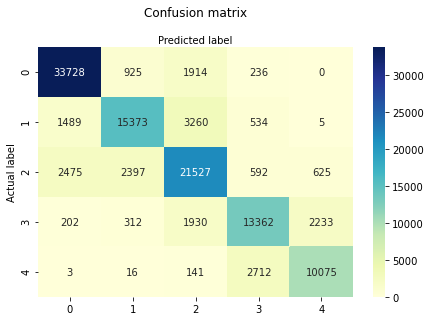

In [11]:
# confusion matrix

cnf_matrix = metrics.confusion_matrix(y, y_hat)
cnf_matrix

class_names = passengersEU['amount_spent_cat'].unique() # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" , fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# plt.show()

plt.savefig('./../data/results/log_reg_confusion_matrix.png', dpi=1000, transparent=True, bbox_inches='tight')

# print(f"precision per predicted label: \t{metrics.precision_score(y, y_hat, average=None)}")
# print(f"recall per actual label: \t{metrics.recall_score(y, y_hat, average=None)}")

print(metrics.classification_report(y, y_hat))

In [12]:
# AUROC
y_hat_probs = logistic_model.predict_proba(X)
metrics.roc_auc_score(y, y_hat_probs, average="weighted", multi_class="ovr")

0.9646274736154162

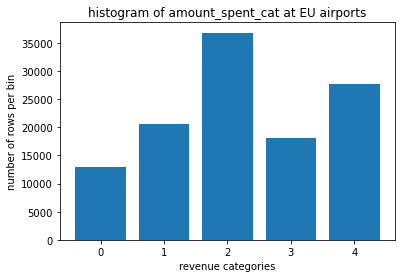

In [36]:
# investigation for (im)balance of customer categories
plt.bar(passengersEU['amount_spent_cat'].unique(), passengersEU['amount_spent_cat'].value_counts())
plt.title('histogram of amount_spent_cat at EU airports')
plt.xlabel('revenue categories')
plt.ylabel('number of rows per bin')
plt.savefig('./../data/results/hist_categories_EU.png', dpi=1000, transparent=True, bbox_inches='tight')

### neural network

In [13]:
# convert integers to dummy variables
y_dummy = to_categorical(y)

In [14]:
# create model
def create_nn_model():
    nn_model = Sequential()
    nn_model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
    nn_model.add(Dense(64, activation='relu'))
    nn_model.add(Dense(32, activation='relu'))
    nn_model.add(Dense(16, activation='relu'))
    nn_model.add(Dense(8, activation='relu'))
    nn_model.add(Dense(5, activation='softmax'))

    # Compile model
    nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(nn_model.summary())

    return(nn_model)

In [15]:
# define optimizer
estimator = KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=64)

In [16]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(estimator, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.886 (0.005)


In [17]:
# train
nn_model = create_nn_model()
history = nn_model.fit(X, y_dummy, epochs=10, batch_size=64)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2816      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 45        
Total params: 13,861
Trainable params: 13,861
Non-trainable params: 0
____________________________________________________

In [18]:
# predict
y_dummy_hat = nn_model.predict(X)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     36803
           1       0.88      0.86      0.87     20661
           2       0.90      0.85      0.87     27616
           3       0.83      0.90      0.86     18039
           4       0.97      0.78      0.87     12947

    accuracy                           0.89    116066
   macro avg       0.90      0.87      0.88    116066
weighted avg       0.90      0.89      0.89    116066



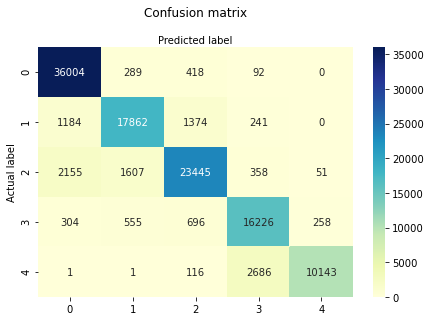

In [19]:
# confusion matrix

y_hat = np.argmax(y_dummy_hat, axis=1)

cnf_matrix = metrics.confusion_matrix(y, y_hat)
cnf_matrix

class_names = passengersEU['amount_spent_cat'].unique() # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" , fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# plt.show()

plt.savefig('./../data/results/nn_confusion_matrix.png', dpi=1000, transparent=True, bbox_inches='tight')

# print(f"precision per predicted label: \t{metrics.precision_score(y, y_hat, average=None)}")
# print(f"recall per actual label: \t{metrics.recall_score(y, y_hat, average=None)}")

print(metrics.classification_report(y, y_hat))

In [20]:
# AUROC
# y_hat_probs = nn_model.predict_proba(X)
metrics.roc_auc_score(y, y_dummy_hat, average="weighted", multi_class="ovr")

0.9899683281867028

## Predict revenues for non-EU airports

In [21]:
### revenue categories

# given information
cat_info = pd.DataFrame(columns=['category','lower_bound','upper_bound','currency'], 
                        data=[['0',0,10,'EUR'], ['1',10,50,'EUR'], ['2',50,150,'EUR'], ['3',150,300,'EUR'], ['4',300,500,'EUR']]
                    )

cat_info['category'] = cat_info['category'].astype(int)

# calculate mean amount
cat_info['mean'] = (cat_info['lower_bound'] + cat_info['upper_bound']) / 2

cat_info

,category,lower_bound,upper_bound,currency,mean
0,0,0,10,EUR,5.0
1,1,10,50,EUR,30.0
2,2,50,150,EUR,100.0
3,3,150,300,EUR,225.0
4,4,300,500,EUR,400.0


In [22]:
### calculate costs
airports_terms_of_lease['total price per year'] = airports_terms_of_lease['sqm of store'] * airports_terms_of_lease['price per sqm/month'] * 12
airports_terms_of_lease.sort_values(by=['total price per year'], ascending=False)

,Airport,sqm of store,price per sqm/month,total price per year
2,EZE,276,23,76176
7,MEL,207,27,67068
10,SFO,181,28,60816
3,HKG,150,28,50400
1,DXB,151,23,41676
4,HND,117,23,32292
5,JFK,97,27,31428
6,KUL,119,19,27132
8,PEK,89,17,18156
9,PVG,59,19,13452


In [23]:
# revenue of interviewees by airport in EU
revenueEU = pd.merge(passengersEU, cat_info, left_on=['amount_spent_cat'], right_on=['category'], how='left')
revenueEU = revenueEU.groupby(['shopped_at']).sum()[['lower_bound','upper_bound','mean']].sort_values(by=['mean'], ascending=False)
revenueEU.columns = ['rev_lower_bound','rev_upper_bound','rev_mean']
revenueEU

,rev_lower_bound,rev_upper_bound,rev_mean
shopped_at,,,
ATH,417080,880690,648885.0
BCN,400930,844690,622810.0
ARN,399780,840780,620280.0
MUC,397880,842650,620265.0
HEL,397760,834490,616125.0
OSL,386450,815960,601205.0
FRA,380240,810720,595480.0
PMI,378080,805450,591765.0
MAN,377180,804910,591045.0


In [24]:
# sample percentage in WW
interviewsWW = pd.DataFrame(passengersWW['shopped_at'].value_counts())
interviewsWW['IATA'] = interviewsWW.index
sampleWW = pd.merge(interviewsWW, passenger_traffic_2019, on=['IATA'])[['IATA','shopped_at','Totalpassengers']]
sampleWW['sample_rate'] = sampleWW['shopped_at'] / sampleWW['Totalpassengers']
sampleWW

,IATA,shopped_at,Totalpassengers,sample_rate
0,JFK,6297,62551072,0.000101
1,DXB,5963,86396757,0.000069
2,DFW,5941,75066956,0.000079
3,HND,5914,85505054,0.000069
4,HKG,5726,71415245,0.000080
5,PEK,5674,100011438,0.000057
6,PVG,5585,76153455,0.000073
7,EZE,5582,12708446,0.000439
8,SFO,5582,57418574,0.000097
9,KUL,5446,62336469,0.000087


### revenue estimation on basis of neural network

In [25]:
### predict
WW_dummy_hat = nn_model.predict(WW)
WW_hat = np.argmax(WW_dummy_hat, axis=1)

print(pd.Series(WW_hat).value_counts())

# add to df
passengersWW_hat = passengersWW.copy()
passengersWW_hat['y_hat'] = WW_hat

0    17864
2    16406
3    14621
4    10903
1     7972
dtype: int64


In [26]:
### revenue of interviewees by airport in WW
revenueWW = pd.merge(passengersWW_hat, cat_info, left_on=['y_hat'], right_on=['category'], how='left')
revenueWW = revenueWW.groupby(['shopped_at']).sum()[['lower_bound','upper_bound','mean']].sort_values(by=['mean'], ascending=False)
revenueWW['shopped_at'] = revenueWW.index
revenueWW.reset_index(drop=True, inplace=True)
revenueWW.columns = ['rev_lower_bound','rev_upper_bound','rev_mean','shopped_at']

# extrapolate to Totalpassengers 2019
revenueWW = pd.merge(revenueWW, sampleWW, left_on=['shopped_at'], right_on=['IATA'], how='left')
revenueWW['total_rev_lower_bound'] = revenueWW['rev_lower_bound'] / revenueWW['sample_rate']
revenueWW['total_rev_upper_bound'] = revenueWW['rev_upper_bound'] / revenueWW['sample_rate']
revenueWW['total_rev_mean'] = revenueWW['rev_mean'] / revenueWW['sample_rate']

# beautify data
revenueWW = revenueWW.sort_values(by=['total_rev_mean'], ascending=False)
revenueWW['rev_mean'] = revenueWW['rev_mean'].astype(int)
revenueWW = pd.merge(revenueWW, 
                        airports, 
                        left_on=['IATA'], 
                        right_on=['iata_code']
                    )[['IATA','name','iso_country','continent','rev_lower_bound','rev_upper_bound','rev_mean','total_rev_lower_bound','total_rev_upper_bound','total_rev_mean']]

revenueWW.columns = ['IATA','Airport Name','iso_country','continent','rev_lower_bound','rev_upper_bound','rev_mean',
                        'Total Revenue Lower Bound','Total Revenue Upper Bound','Total Revenue Average']

revenueWW

,IATA,Airport Name,iso_country,continent,rev_lower_bound,rev_upper_bound,rev_mean,Total Revenue Lower Bound,Total Revenue Upper Bound,Total Revenue Average
0,PEK,Beijing Capital International Airport,CN,AS,526760,1065600,796180,9.284812e+09,1.878255e+10,1.403368e+10
1,HND,Tokyo Haneda International Airport,JP,AS,552470,1115940,834205,7.987653e+09,1.613434e+10,1.206100e+10
2,DXB,Dubai International Airport,AE,AS,543400,1108460,825930,7.873218e+09,1.606026e+10,1.196674e+10
3,PVG,Shanghai Pudong International Airport,CN,AS,535890,1082400,809145,7.307050e+09,1.475891e+10,1.103298e+10
4,DFW,Dallas Fort Worth International Airport,US,NH,575620,1157370,866495,7.273193e+09,1.462384e+10,1.094852e+10
5,HKG,Hong Kong International Airport,HK,AS,557650,1119600,838625,6.955067e+09,1.396376e+10,1.045941e+10
6,SIN,Singapore Changi Airport,SG,AS,531830,1063020,797425,6.871324e+09,1.373438e+10,1.030285e+10
7,KUL,Kuala Lumpur International Airport,MY,AS,558390,1115690,837040,6.391491e+09,1.277051e+10,9.580999e+09
8,JFK,John F Kennedy International Airport,US,NH,561780,1146850,854315,5.580426e+09,1.139220e+10,8.486314e+09
9,SFO,San Francisco International Airport,US,NH,542170,1087640,814905,5.576967e+09,1.118788e+10,8.382423e+09


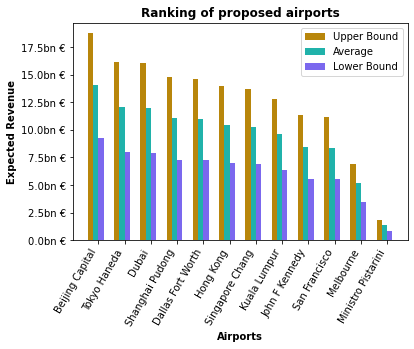

In [27]:
### plot ranking

x = revenueWW.index.to_numpy()
width = 0.2

def billions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}bn €'.format(x*1e-9)

fig, ax = plt.subplots()
# Use automatic FuncFormatter creation
ax.yaxis.set_major_formatter(billions)
ax.bar(x-0.2, revenueWW['Total Revenue Upper Bound'], width, color='darkgoldenrod', label='Upper Bound')
ax.bar(x, revenueWW['Total Revenue Average'], width, color='lightseagreen', label='Average')
ax.bar(x+0.2, revenueWW['Total Revenue Lower Bound'], width, color='mediumslateblue', label='Lower Bound')

ax.set_xticks(x + width / 2)
x_labels = revenueWW['Airport Name'].str.replace('Airport', '').str.replace('International', '').str[:-2]
ax.set_xticklabels(x_labels, rotation='60', ha='right')

ax.set_title('Ranking of proposed airports', fontweight='bold')
ax.set_xlabel('Airports', fontweight='bold')
ax.set_ylabel('Expected Revenue', fontweight='bold')
ax.legend()


plt.savefig('./../data/results/ranking.png', dpi=1000, transparent=True, bbox_inches='tight')

In [28]:
### save ranking result
revenueWW[['IATA','Airport Name','Total Revenue Lower Bound','Total Revenue Upper Bound','Total Revenue Average']].to_excel('../data/results/revenueWW.xlsx')

In [29]:
# ### profit
# revenue_costsWW = pd.merge(
#                         revenueWW, airports_terms_of_lease, left_on=['shopped_at'], right_on=['Airport'], how='left',
#                     )[['shopped_at','rev_lower_bound','rev_upper_bound','rev_mean','total price per year']]
# revenue_costsWW
# revenue_costsWW.columns = ['shopped_at','rev_lower_bound','rev_upper_bound','rev_mean','costs']
# profitWW = revenue_costsWW.copy()
# profitWW['profit_lower_bound'] = profitWW['rev_lower_bound'] - profitWW['costs']
# profitWW['profit_upper_bound'] = profitWW['rev_upper_bound'] - profitWW['costs']
# profitWW['profit_mean'] = profitWW['rev_mean'] - profitWW['costs']

# # beautify data
# profitWW = profitWW.sort_values(by=['profit_mean'], ascending=False)
# profitWW['rev_mean'] = profitWW['rev_mean'].astype(int)
# profitWW['profit_mean'] = profitWW['profit_mean'].astype(int)
# profitWW = pd.merge(
#                 profitWW, airports, left_on=['shopped_at'], right_on=['iata_code']
#             )[['shopped_at','name','iso_country','continent','rev_lower_bound','rev_upper_bound','rev_mean','costs','profit_lower_bound','profit_upper_bound','profit_mean']]

# profitWW